In [4]:
import math 
import numpy as np
import matplotlib.pyplot as plt


In [5]:
def f(x):
    return 3*x**2 -4*x + 5

In [6]:
f(3.0)

20.0

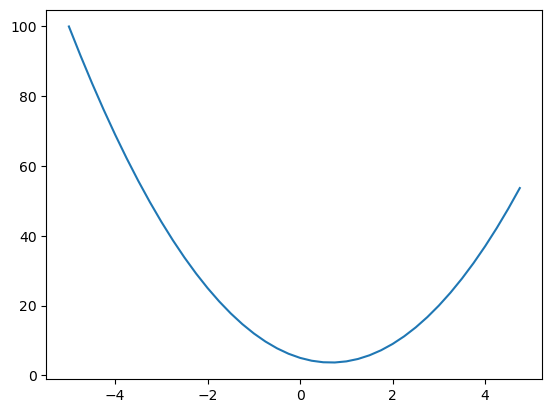

In [13]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [19]:
h = 0.000001
x = 3.0 
(f(x+h)-f(x))/h


14.000003002223593

In [20]:
#incresing complexity
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [24]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h 
d2 = a*b + c

print('d1' , d1)
print('d2' , d2)
print('slope' , (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [244]:
class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self._prev =  set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self): 
        return self * -1

    def __sub__(self, other): 
        return self + (-other)
      
    def __mul__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
            
        return out

    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float values for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += out.grad * other * self.data ** (other-1)
        out._backward = _backward

        return out
        
    def __rmul__(self, other):
        return(self*other)

    def __truediv__(self, other): 
        return self* other**-1
        
    def tanh(self):
        x =  self.data
        out = Value(np.tanh(x), (self, ), 'tanh' )
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        out  = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad = out.grad * out.data
        out.backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for  node in reversed(topo):
            node._backward()


a = Value(2.0,label = 'a')
b = Value(-3.0, label='b')
c = Value(10.0,label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'l'


In [198]:
from graphviz import Digraph  # to visualize our neural network as we go up in complexity

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [199]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'


In [200]:
o.grad = 1.0
o.backward()

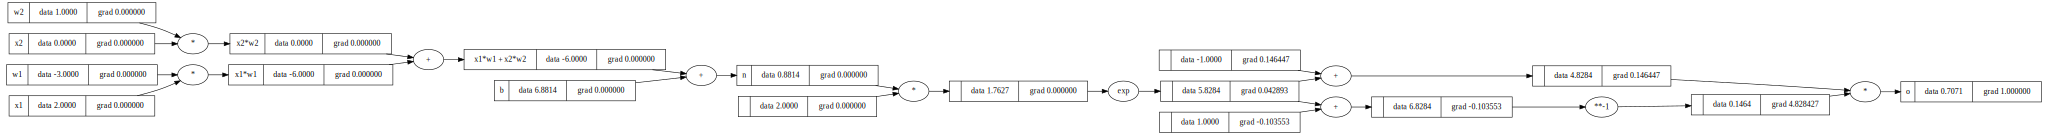

In [201]:
draw_dot(o)

In [210]:
# import torch 
# import random 

# x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
# x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
# w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
# w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
# b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
# n = x1*w1 + x2*w2 + b
# o = torch.tanh(n)

# print(o.data.item())
# o.backward()

# print('---')
# print('x2', x2.grad.item())
# print('w2', w2.grad.item())
# print('x1', x1.grad.item())
# print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [214]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [354]:
class Neuron: 

    def __init__(self,nin): 
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b )
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self,nin,nout): #nout is the number of neurons 
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    
    def __init__(self, nin, nouts): #nouts is a list of the number of neurons in each layer
        sz = [nin] + nouts
        print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x)
        return x 

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]




In [359]:
# x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
len(n.parameters())


[3, 4, 4, 1]


41

In [360]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [368]:
for k in range(20):
    #forward pass
    ypred =  [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt,yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)
  
    

0 0.0002680333993181713
1 0.00026777852954685947
2 0.00026752413412793705
3 0.00026727021173953607
4 0.0002670167610647391
5 0.000266763780791558
6 0.00026651126961290414
7 0.0002662592262265652
8 0.000266007649335193
9 0.00026575653764626927
10 0.00026550588987208886
11 0.0002652557047297338
12 0.0002650059809410504
13 0.00026475671723262626
14 0.0002645079123357751
15 0.0002642595649865078
16 0.0002640116739255092
17 0.00026376423789811895
18 0.0002635172556543113
19 0.0002632707259486739


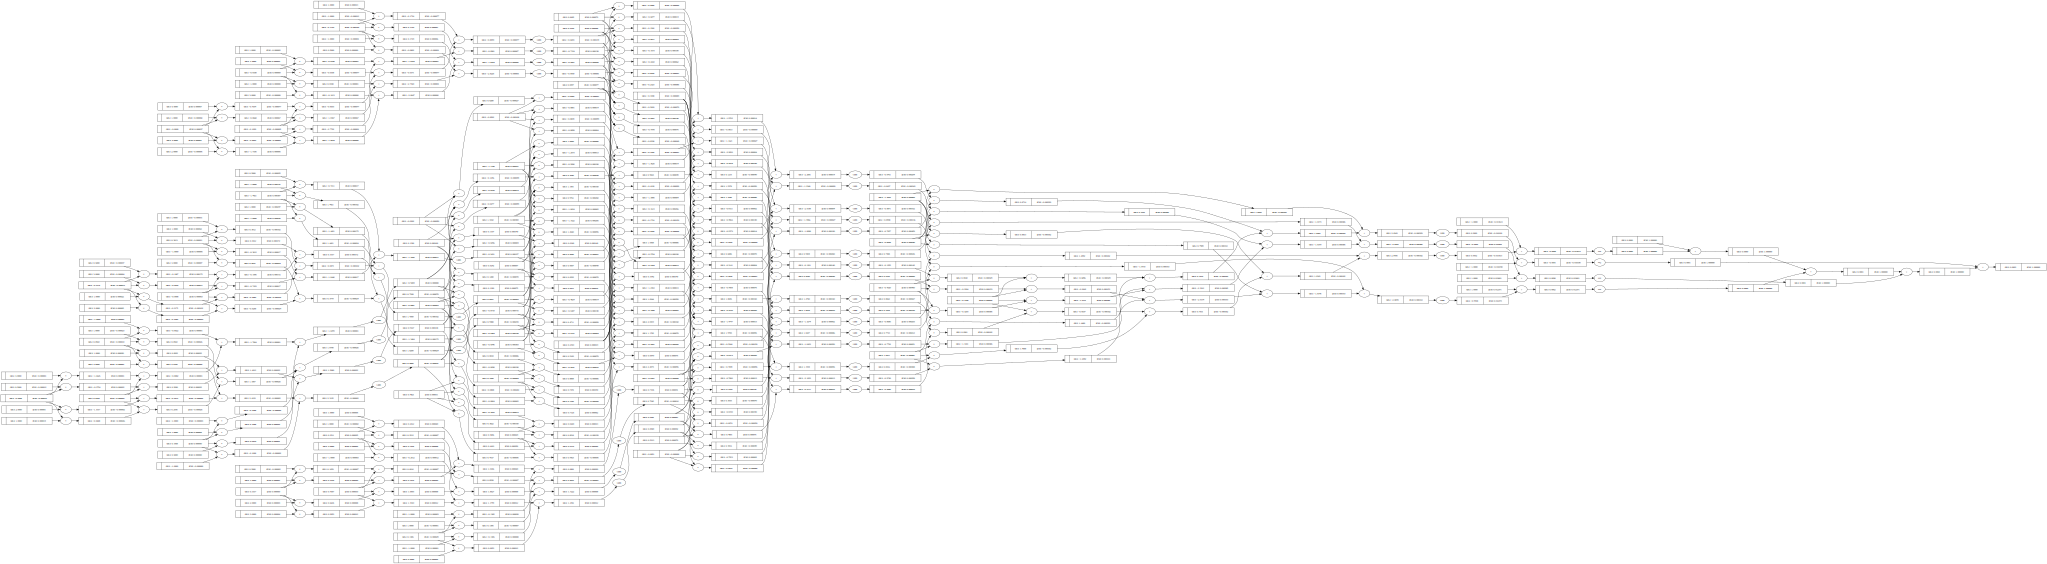

In [369]:
draw_dot(loss)